In [1]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 7.3 MB/s 
     |████████████████████████████████| 3.5 MB 11.4 MB/s 
     |████████████████████████████████| 145 kB 8.4 MB/s 
     |████████████████████████████████| 112 kB 49.3 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 53.8 MB/s 


In [2]:
import torch
import numpy
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
import matplotlib.pyplot as plt

In [3]:
mymin = lambda a, b : torch.minimum(a, b)
mymax = lambda a, b : torch.maximum(a, b)
mysum = lambda a, b : a + b
mean = lambda a, b : (a + b) / 2
hadamard = lambda a, b : a * b
myconcat = lambda a, b : torch.cat((a,b))

In [4]:
from typing import Optional, Tuple, Union, Any

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import (Adj, NoneType, OptPairTensor, OptTensor,
                                    Size)
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros


class CustomGATConv(MessagePassing):

    _alpha: OptTensor

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int = 1,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        agg_func: Optional[Any] = lambda x,y: (x,y),
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value
        self.agg_func = agg_func

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)

    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):


        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = self.agg_func(alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # propagate_type: (x: OptPairTensor, alpha: OptPairTensor, edge_attr: OptTensor)  # noqa
        out = self.propagate(edge_index, x=x, alpha=alpha, edge_attr=edge_attr,
                             size=size)

        alpha = self._alpha
        assert alpha is not None
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out += self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out

    def message(self, x_j: Tensor, alpha_j: Tensor, alpha_i: OptTensor,
                edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            assert self.lin_edge is not None
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha  # Save for later use.
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

In [5]:
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

data = dataset[0]

Processing...


Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Done!


In [6]:
class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels,agg_func,num_heads,num_ouput_heads):
        super().__init__()

        self.conv1 = CustomGATConv(in_channels, 8, heads=num_heads, dropout=0.6,agg_func=agg_func)
        # On the Pubmed dataset, use heads=8 in conv2.
        self.conv2 = CustomGATConv(num_heads * 8, out_channels, heads=num_ouput_heads, concat=False,
                             dropout=0.6,agg_func=agg_func)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=-1)

In [7]:
def make_model(dataset,agg_func,num_heads,num_ouput_heads):
  data = dataset[0]
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = Net(dataset.num_features, dataset.num_classes,agg_func,num_heads,num_ouput_heads).to(device)
  data = data.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

  losses = []


  def train(data):
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index)
      loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss


  @torch.no_grad()
  def test(data):
      model.eval()
      out, accs = model(data.x, data.edge_index), []
      for _, mask in data('train_mask', 'val_mask', 'test_mask'):
          acc = float((out[mask].argmax(-1) == data.y[mask]).sum() / mask.sum())
          accs.append(acc)
      return accs


  for epoch in range(1, 201):
      loss = train(data)
      train_acc, val_acc, test_acc = test(data)

      losses.append(loss.item())


      print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, '
            f'Test: {test_acc:.4f}')

In [15]:
# name_data = 'Cora'
# name_data = 'Citeseer'
name_data = 'Pubmed'

dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

make_model(dataset,hadamard,8,8)

Epoch: 001, Train: 0.5833, Val: 0.4560, Test: 0.4840
Epoch: 002, Train: 0.6833, Val: 0.6100, Test: 0.6240
Epoch: 003, Train: 0.8500, Val: 0.6660, Test: 0.6800
Epoch: 004, Train: 0.7500, Val: 0.5940, Test: 0.5780
Epoch: 005, Train: 0.7333, Val: 0.5420, Test: 0.5430
Epoch: 006, Train: 0.7500, Val: 0.5780, Test: 0.5670
Epoch: 007, Train: 0.8167, Val: 0.6620, Test: 0.6540
Epoch: 008, Train: 0.8833, Val: 0.7100, Test: 0.7040
Epoch: 009, Train: 0.9000, Val: 0.7380, Test: 0.7150
Epoch: 010, Train: 0.9167, Val: 0.7220, Test: 0.7160
Epoch: 011, Train: 0.9167, Val: 0.7240, Test: 0.7120
Epoch: 012, Train: 0.9000, Val: 0.7280, Test: 0.7130
Epoch: 013, Train: 0.9000, Val: 0.7320, Test: 0.7060
Epoch: 014, Train: 0.8833, Val: 0.7320, Test: 0.7070
Epoch: 015, Train: 0.8833, Val: 0.7300, Test: 0.7090
Epoch: 016, Train: 0.8833, Val: 0.7280, Test: 0.7080
Epoch: 017, Train: 0.8833, Val: 0.7280, Test: 0.7100
Epoch: 018, Train: 0.8833, Val: 0.7320, Test: 0.7070
Epoch: 019, Train: 0.9000, Val: 0.7320, Test: 

Text(0, 0.5, 'loss')

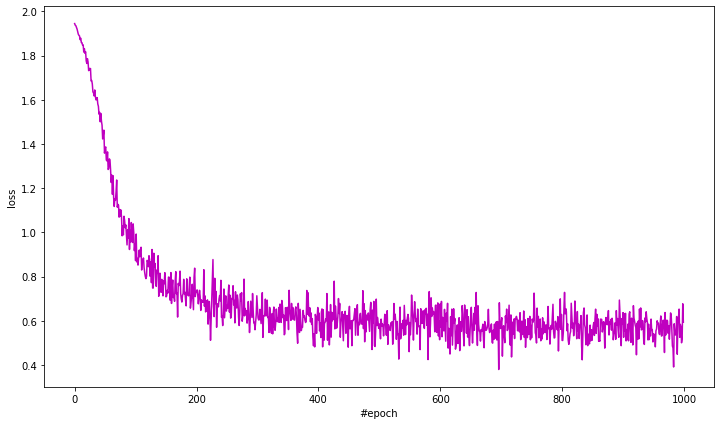

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(losses,c='m')
plt.xlabel('#epoch')
plt.ylabel('loss')


# **part 5 : 5 head with different aggregation functions**

In [16]:
def five_head_func(alpha_src,alpha_dst):
  alpha_1 = mymin(alpha_src[:,0:1], alpha_dst[:,0:1])
  alpha_2 = mymax(alpha_src[:,1:2], alpha_dst[:,1:2])
  alpha_3 = mean(alpha_src[:,2:3], alpha_dst[:,2:3])
  alpha_4 = hadamard(alpha_src[:,3:4], alpha_dst[:,3:4])
  alpha_5 = mysum(alpha_src[:,4:5], alpha_dst[:,4:5])
  tensors= [alpha_1,alpha_2,alpha_3,alpha_4,alpha_5]
  alpha = torch.cat(tensors, 1)

  return alpha

In [21]:
# name_data = 'Cora'
name_data = 'Citeseer'
# name_data = 'Pubmed'

dataset = Planetoid(root= '/tmp/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

make_model(dataset,five_head_func,5,1)

Epoch: 001, Train: 0.1750, Val: 0.1880, Test: 0.1690
Epoch: 002, Train: 0.1667, Val: 0.1880, Test: 0.1690
Epoch: 003, Train: 0.1917, Val: 0.1900, Test: 0.1700
Epoch: 004, Train: 0.2250, Val: 0.1980, Test: 0.1750
Epoch: 005, Train: 0.3083, Val: 0.2060, Test: 0.1900
Epoch: 006, Train: 0.4000, Val: 0.2400, Test: 0.2260
Epoch: 007, Train: 0.5667, Val: 0.3440, Test: 0.3330
Epoch: 008, Train: 0.7583, Val: 0.4960, Test: 0.4770
Epoch: 009, Train: 0.8583, Val: 0.5740, Test: 0.5640
Epoch: 010, Train: 0.8667, Val: 0.5340, Test: 0.5000
Epoch: 011, Train: 0.8500, Val: 0.4960, Test: 0.4710
Epoch: 012, Train: 0.8250, Val: 0.4820, Test: 0.4400
Epoch: 013, Train: 0.8333, Val: 0.4680, Test: 0.4370
Epoch: 014, Train: 0.8417, Val: 0.4820, Test: 0.4510
Epoch: 015, Train: 0.8417, Val: 0.4940, Test: 0.4580
Epoch: 016, Train: 0.8417, Val: 0.4820, Test: 0.4640
Epoch: 017, Train: 0.8500, Val: 0.4780, Test: 0.4680
Epoch: 018, Train: 0.8833, Val: 0.5060, Test: 0.4900
Epoch: 019, Train: 0.8833, Val: 0.5340, Test: 